In [25]:
import json
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import pickle
from catboost import CatBoostRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error, r2_score
import warnings
warnings.filterwarnings('ignore')

In [26]:
class SalesPredictionModel:
    def __init__(self):
        self.model = None
        self.label_encoders = {}
        self.category_columns = []
        self.feature_columns = []
        
    def load_and_preprocess_data(self, json_file_path):
        """Load and preprocess the sales data"""
        print("Loading data...")
        with open(json_file_path, "r", encoding="utf-8") as file:
            data = json.load(file)
        
        df = pd.DataFrame(data)
        print(f"Loaded {len(df)} records")
        
        # Convert date to datetime
        df['Buying Date'] = pd.to_datetime(df['Buying Date'])
        
        # Extract date features
        df['Year'] = df['Buying Date'].dt.year
        df['Month'] = df['Buying Date'].dt.month
        df['Day'] = df['Buying Date'].dt.day
        df['DayOfWeek'] = df['Buying Date'].dt.dayofweek
        df['Quarter'] = df['Buying Date'].dt.quarter
        
        # Convert discount percentage to float
        df['Discount_Numeric'] = df['Discount'].str.replace('%', '').astype(float)
        
        # Calculate total sales amount
        df['Total_Sales'] = df['Quantity'] * df['Unit Price'] * (1 - df['Discount_Numeric'] / 100)
        
        # Add simulated inflation rate (you'll replace this with actual data)
        df['Inflation_Rate'] = self.generate_inflation_data(df['Buying Date'])
        
        return df
    
    def generate_inflation_data(self, dates):
        """Generate simulated inflation rate data based on dates"""
        # This is simulated data - replace with actual inflation data
        np.random.seed(42)
        base_inflation = 8.0  # Base inflation rate for Sri Lanka
        
        inflation_rates = []
        for date in dates:
            # Add some seasonal and random variation
            seasonal_factor = 0.5 * np.sin(2 * np.pi * date.month / 12)
            random_factor = np.random.normal(0, 0.3)
            monthly_trend = (date.month - 1) * 0.1  # Slight monthly trend
            
            inflation = base_inflation + seasonal_factor + random_factor + monthly_trend
            inflation_rates.append(max(0, inflation))  # Ensure non-negative
        
        return inflation_rates
    
    def prepare_features_and_targets(self, df):
        """Prepare features and target variables for multi-output regression"""
        print("Preparing features and targets...")
        
        # Group by category and date to get daily sales by category
        daily_category_sales = df.groupby(['Product Category', 'Buying Date']).agg({
            'Quantity': 'sum',
            'Total_Sales': 'sum',
            'Inflation_Rate': 'first',
            'Year': 'first',
            'Month': 'first',
            'Day': 'first',
            'DayOfWeek': 'first',
            'Quarter': 'first'
        }).reset_index()
        
        # Pivot to get categories as columns
        category_sales_pivot = daily_category_sales.pivot_table(
            index=['Buying Date', 'Inflation_Rate', 'Year', 'Month', 'Day', 'DayOfWeek', 'Quarter'],
            columns='Product Category',
            values='Quantity',
            fill_value=0
        ).reset_index()
        
        # Prepare features
        feature_cols = ['Inflation_Rate', 'Year', 'Month', 'Day', 'DayOfWeek', 'Quarter']
        X = category_sales_pivot[feature_cols]
        
        # Prepare targets (sales quantities by category)
        category_columns = [col for col in category_sales_pivot.columns if col not in feature_cols + ['Buying Date']]
        y = category_sales_pivot[category_columns]
        
        self.category_columns = category_columns
        self.feature_columns = feature_cols
        
        print(f"Features shape: {X.shape}")
        print(f"Targets shape: {y.shape}")
        print(f"Categories: {category_columns}")
        
        return X, y, category_sales_pivot
    
    def train_model(self, X, y):
        """Train Multi-Output CatBoost Regression model"""
        print("Training Multi-Output CatBoost model...")
        
        # Split data
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.2, random_state=42
        )
        
        # Initialize CatBoost with multi-output support
        self.model = CatBoostRegressor(
            iterations=1000,
            depth=6,
            learning_rate=0.1,
            loss_function='MultiRMSE',  # Multi-output RMSE
            random_seed=42,
            verbose=100
        )
        
        # Train the model
        self.model.fit(
            X_train, y_train,
            eval_set=(X_test, y_test),
            early_stopping_rounds=100,
            verbose=100
        )
        
        # Make predictions
        y_pred = self.model.predict(X_test)
        
        # Calculate metrics for each category
        print("\nModel Performance:")
        for i, category in enumerate(self.category_columns):
            mse = mean_squared_error(y_test.iloc[:, i], y_pred[:, i])
            r2 = r2_score(y_test.iloc[:, i], y_pred[:, i])
            print(f"{category}: MSE={mse:.2f}, R²={r2:.3f}")
        
        return X_test, y_test, y_pred
    
    def predict_sales(self, date_str, inflation_rate):
        """Predict sales for given date and inflation rate"""
        if self.model is None:
            raise ValueError("Model not trained yet!")
        
        # Parse date
        date = pd.to_datetime(date_str)
        
        # Create feature vector
        features = pd.DataFrame({
            'Inflation_Rate': [inflation_rate],
            'Year': [date.year],
            'Month': [date.month],
            'Day': [date.day],
            'DayOfWeek': [date.dayofweek],
            'Quarter': [date.quarter]
        })
        
        # Make prediction
        prediction = self.model.predict(features)[0]
        
        # Format output
        result = {}
        for i, category in enumerate(self.category_columns):
            # Ensure non-negative predictions
            sales_kg = max(0, prediction[i])
            result[category] = round(sales_kg, 2)
        
        return result
    
    def save_model(self, filepath='sales_prediction_model.pkl'):
        """Save the trained model and metadata"""
        model_data = {
            'model': self.model,
            'category_columns': self.category_columns,
            'feature_columns': self.feature_columns,
            'label_encoders': self.label_encoders
        }
        
        with open(filepath, 'wb') as f:
            pickle.dump(model_data, f)
        print(f"Model saved to {filepath}")
    
    def load_model(self, filepath='sales_prediction_model.pkl'):
        """Load a trained model"""
        with open(filepath, 'rb') as f:
            model_data = pickle.load(f)
        
        self.model = model_data['model']
        self.category_columns = model_data['category_columns']
        self.feature_columns = model_data['feature_columns']
        self.label_encoders = model_data['label_encoders']
        print(f"Model loaded from {filepath}")

In [27]:
def main():
    """Main training pipeline"""
    # Initialize model
    sales_model = SalesPredictionModel()
    
    # Load and preprocess data
    df = sales_model.load_and_preprocess_data("datasets/generated_sales_dataset.json")
    
    # Prepare features and targets
    X, y, processed_df = sales_model.prepare_features_and_targets(df)
    
    # Train model
    X_test, y_test, y_pred = sales_model.train_model(X, y)
    
    # Save model
    sales_model.save_model('sales_prediction_model.pkl')
    
    # Test prediction
    print("\nTesting prediction:")
    test_date = "2024-12-01"
    test_inflation = 9.5
    
    prediction = sales_model.predict_sales(test_date, test_inflation)
    print(f"\nPredicted sales for {test_date} with {test_inflation}% inflation:")
    for category, sales in prediction.items():
        print(f"{category}: {sales} kg")
    
    return sales_model

if __name__ == "__main__":
    model = main()

Loading data...
Loaded 2739 records
Preparing features and targets...
Features shape: (1669, 6)
Targets shape: (1669, 11)
Categories: ['Fresh Meat - Beef', 'Fresh Meat - Chicken', 'Fresh Meat - Game', 'Fresh Meat - Lamb', 'Fresh Meat - Pork', 'Fresh Meat - Turkey & Other', 'Fresh Seafood - Fish', 'Fresh Seafood - Shellfish', 'Fresh Seafood - Specialty', 'Frozen Meat & Seafood', 'Marinated Meat & Ready to Cook']
Training Multi-Output CatBoost model...
0:	learn: 6.5824020	test: 7.5453041	best: 7.5453041 (0)	total: 6.05ms	remaining: 6.04s
100:	learn: 5.2318289	test: 7.7860395	best: 7.5413513 (5)	total: 461ms	remaining: 4.11s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 7.541351305
bestIteration = 5

Shrink model to first 6 iterations.

Model Performance:
Fresh Meat - Beef: MSE=0.16, R²=-0.185
Fresh Meat - Chicken: MSE=11.36, R²=0.002
Fresh Meat - Game: MSE=0.27, R²=-0.004
Fresh Meat - Lamb: MSE=0.89, R²=-0.021
Fresh Meat - Pork: MSE=0.35, R²=-0.002
Fresh Meat - Turke

#Test The Model

In [33]:

import matplotlib.pyplot as plt
import seaborn as sns
import warnings

warnings.filterwarnings('ignore')

In [34]:
# Set up plotting style
plt.style.use('default')
sns.set_palette("husl")

In [35]:
print("Sales Prediction Model Testing")
print("=" * 50)

Sales Prediction Model Testing


In [36]:
def load_saved_model(model_path='sales_prediction_model.pkl'):
    """Load the saved model and its metadata"""
    try:
        with open(model_path, 'rb') as f:
            model_data = pickle.load(f)
        
        print(f"✅ Model loaded successfully from {model_path}")
        print(f"Model type: {type(model_data['model'])}")
        print(f"Feature columns: {model_data['feature_columns']}")
        print(f"Category columns: {model_data['category_columns']}")
        
        return model_data
    except FileNotFoundError:
        print(f"❌ Model file '{model_path}' not found!")
        print("Please run the training script first to generate the model.")
        return None
    except Exception as e:
        print(f"❌ Error loading model: {e}")
        return None

In [37]:
model_data = load_saved_model()

✅ Model loaded successfully from sales_prediction_model.pkl
Model type: <class 'catboost.core.CatBoostRegressor'>
Feature columns: ['Inflation_Rate', 'Year', 'Month', 'Day', 'DayOfWeek', 'Quarter']
Category columns: ['Fresh Meat - Beef', 'Fresh Meat - Chicken', 'Fresh Meat - Game', 'Fresh Meat - Lamb', 'Fresh Meat - Pork', 'Fresh Meat - Turkey & Other', 'Fresh Seafood - Fish', 'Fresh Seafood - Shellfish', 'Fresh Seafood - Specialty', 'Frozen Meat & Seafood', 'Marinated Meat & Ready to Cook']


In [38]:
def predict_sales_from_model(model_data, date_str, inflation_rate):
    """Make predictions using the loaded model"""
    if model_data is None:
        return None
    
    try:
        # Parse date
        date = pd.to_datetime(date_str)
        
        # Create feature vector
        features = pd.DataFrame({
            'Inflation_Rate': [inflation_rate],
            'Year': [date.year],
            'Month': [date.month],
            'Day': [date.day],
            'DayOfWeek': [date.dayofweek],
            'Quarter': [date.quarter]
        })
        
        # Make prediction
        model = model_data['model']
        category_columns = model_data['category_columns']
        
        prediction = model.predict(features)[0]
        
        # Format output
        result = {}
        for i, category in enumerate(category_columns):
            sales_kg = max(0, round(prediction[i], 2))
            result[category] = sales_kg
        
        return result
        
    except Exception as e:
        print(f"❌ Prediction error: {e}")
        return None

In [39]:
if model_data is not None:
    print("\n" + "=" * 50)
    print("SINGLE PREDICTION TEST")
    print("=" * 50)
    
    test_date = "2024-12-01"
    test_inflation = 9.5
    
    prediction = predict_sales_from_model(model_data, test_date, test_inflation)
    
    if prediction:
        print(f"\n📅 Date: {test_date}")
        print(f"📈 Inflation Rate: {test_inflation}%")
        print("\n🛒 Predicted Sales (kg):")
        print("-" * 30)
        
        total_sales = 0
        for category, sales in prediction.items():
            print(f"{category:<35}: {sales:>8.2f} kg")
            total_sales += sales
        
        print("-" * 44)
        print(f"{'TOTAL':<35}: {total_sales:>8.2f} kg")


SINGLE PREDICTION TEST

📅 Date: 2024-12-01
📈 Inflation Rate: 9.5%

🛒 Predicted Sales (kg):
------------------------------
Fresh Meat - Beef                  :     0.27 kg
Fresh Meat - Chicken               :     0.50 kg
Fresh Meat - Game                  :     0.04 kg
Fresh Meat - Lamb                  :     0.32 kg
Fresh Meat - Pork                  :     0.11 kg
Fresh Meat - Turkey & Other        :     0.35 kg
Fresh Seafood - Fish               :     0.70 kg
Fresh Seafood - Shellfish          :     0.38 kg
Fresh Seafood - Specialty          :     0.43 kg
Frozen Meat & Seafood              :     0.43 kg
Marinated Meat & Ready to Cook     :     0.17 kg
--------------------------------------------
TOTAL                              :     3.70 kg



MULTIPLE SCENARIO TESTING

📊 Low inflation scenario
   Date: 2024-01-15, Inflation: 6.5%
   Top 3 categories:
   1. Fresh Seafood - Fish: 1.36 kg
   2. Fresh Meat - Chicken: 1.11 kg
   3. Fresh Meat - Beef: 0.60 kg

📊 Medium inflation scenario
   Date: 2024-06-15, Inflation: 8.0%
   Top 3 categories:
   1. Fresh Seafood - Fish: 0.58 kg
   2. Fresh Meat - Chicken: 0.49 kg
   3. Fresh Seafood - Shellfish: 0.39 kg

📊 High inflation scenario
   Date: 2024-12-01, Inflation: 12.0%
   Top 3 categories:
   1. Fresh Seafood - Fish: 0.70 kg
   2. Fresh Meat - Chicken: 0.50 kg
   3. Fresh Seafood - Specialty: 0.43 kg

📊 Very high inflation scenario
   Date: 2025-03-20, Inflation: 15.0%
   Top 3 categories:
   1. Fresh Seafood - Fish: 0.69 kg
   2. Frozen Meat & Seafood: 0.54 kg
   3. Fresh Meat - Chicken: 0.43 kg

📊 Very low inflation scenario
   Date: 2024-03-10, Inflation: 4.0%
   Top 3 categories:
   1. Fresh Seafood - Fish: 0.60 kg
   2. Fresh Meat - Chicken: 0.54 kg
   3. Frozen Meat & Seaf

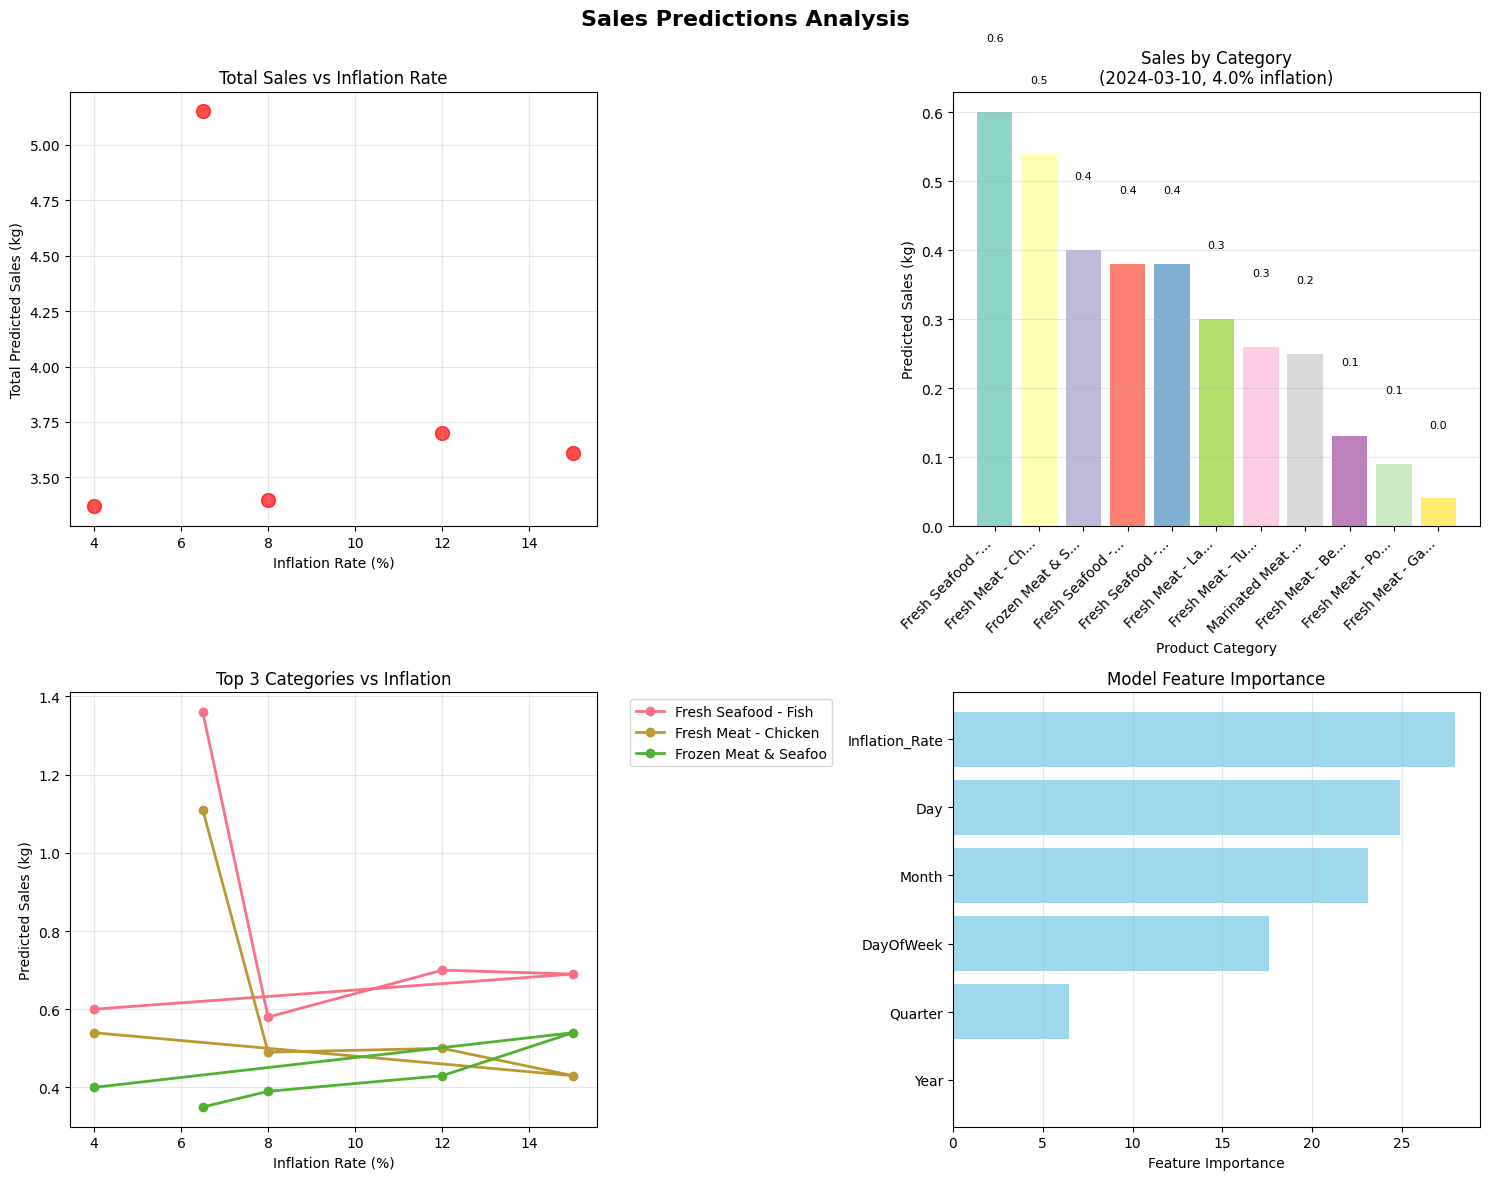

In [40]:
if model_data is not None:
    print("\n" + "=" * 50)
    print("MULTIPLE SCENARIO TESTING")
    print("=" * 50)
    
    test_scenarios = [
        ("2024-01-15", 6.5, "Low inflation scenario"),
        ("2024-06-15", 8.0, "Medium inflation scenario"),
        ("2024-12-01", 12.0, "High inflation scenario"),
        ("2025-03-20", 15.0, "Very high inflation scenario"),
        ("2024-03-10", 4.0, "Very low inflation scenario")
    ]
    
    results_df = []
    
    for date, inflation, description in test_scenarios:
        prediction = predict_sales_from_model(model_data, date, inflation)
        
        if prediction:
            print(f"\n📊 {description}")
            print(f"   Date: {date}, Inflation: {inflation}%")
            
            row_data = {
                'Date': date,
                'Inflation_Rate': inflation,
                'Scenario': description
            }
            row_data.update(prediction)
            results_df.append(row_data)
            
            # Show top 3 categories
            sorted_categories = sorted(prediction.items(), key=lambda x: x[1], reverse=True)[:3]
            print("   Top 3 categories:")
            for i, (cat, sales) in enumerate(sorted_categories, 1):
                print(f"   {i}. {cat}: {sales:.2f} kg")
    
    # Convert to DataFrame for analysis
    if results_df:
        results_df = pd.DataFrame(results_df)
        print(f"\n✅ Generated {len(results_df)} predictions")

# Cell 5: Visualize predictions
if model_data is not None and 'results_df' in locals():
    print("\n" + "=" * 50)
    print("PREDICTION VISUALIZATION")
    print("=" * 50)
    
    # Create visualizations
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    fig.suptitle('Sales Predictions Analysis', fontsize=16, fontweight='bold')
    
    # 1. Total sales vs inflation rate
    category_cols = model_data['category_columns']
    results_df['Total_Sales'] = results_df[category_cols].sum(axis=1)
    
    axes[0, 0].scatter(results_df['Inflation_Rate'], results_df['Total_Sales'], 
                       c='red', alpha=0.7, s=100)
    axes[0, 0].set_xlabel('Inflation Rate (%)')
    axes[0, 0].set_ylabel('Total Predicted Sales (kg)')
    axes[0, 0].set_title('Total Sales vs Inflation Rate')
    axes[0, 0].grid(True, alpha=0.3)
    
    # 2. Sales by category (bar chart for latest prediction)
    latest_pred = results_df.iloc[-1]
    category_sales = [(cat, latest_pred[cat]) for cat in category_cols]
    category_sales.sort(key=lambda x: x[1], reverse=True)
    
    categories, sales = zip(*category_sales)
    colors = plt.cm.Set3(np.linspace(0, 1, len(categories)))
    
    bars = axes[0, 1].bar(range(len(categories)), sales, color=colors)
    axes[0, 1].set_xlabel('Product Category')
    axes[0, 1].set_ylabel('Predicted Sales (kg)')
    axes[0, 1].set_title(f'Sales by Category\n({latest_pred["Date"]}, {latest_pred["Inflation_Rate"]}% inflation)')
    axes[0, 1].set_xticks(range(len(categories)))
    axes[0, 1].set_xticklabels([cat[:15] + '...' if len(cat) > 15 else cat 
                                for cat in categories], rotation=45, ha='right')
    axes[0, 1].grid(True, alpha=0.3, axis='y')
    
    # Add value labels on bars
    for bar, value in zip(bars, sales):
        axes[0, 1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.1,
                        f'{value:.1f}', ha='center', va='bottom', fontsize=8)
    
    # 3. Inflation impact on top categories
    top_3_categories = [cat for cat, _ in category_sales[:3]]
    
    for i, category in enumerate(top_3_categories):
        axes[1, 0].plot(results_df['Inflation_Rate'], results_df[category], 
                        marker='o', label=category[:20], linewidth=2, markersize=6)
    
    axes[1, 0].set_xlabel('Inflation Rate (%)')
    axes[1, 0].set_ylabel('Predicted Sales (kg)')
    axes[1, 0].set_title('Top 3 Categories vs Inflation')
    axes[1, 0].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    axes[1, 0].grid(True, alpha=0.3)
    
    # 4. Model feature importance (if available)
    try:
        feature_importance = model_data['model'].get_feature_importance()
        feature_names = model_data['feature_columns']
        
        importance_df = pd.DataFrame({
            'Feature': feature_names,
            'Importance': feature_importance
        }).sort_values('Importance', ascending=True)
        
        axes[1, 1].barh(importance_df['Feature'], importance_df['Importance'], 
                        color='skyblue', alpha=0.8)
        axes[1, 1].set_xlabel('Feature Importance')
        axes[1, 1].set_title('Model Feature Importance')
        axes[1, 1].grid(True, alpha=0.3, axis='x')
        
    except Exception as e:
        axes[1, 1].text(0.5, 0.5, f'Feature importance\nnot available\n\nError: {str(e)}', 
                        ha='center', va='center', transform=axes[1, 1].transAxes)
        axes[1, 1].set_title('Feature Importance')
    
    plt.tight_layout()
    plt.show()

# Cell 6: Interactive prediction function
def interactive_prediction():
    """Interactive function for making predictions"""
    if model_data is None:
        print("❌ Model not loaded. Cannot make predictions.")
        return
    
    print("\n" + "=" * 50)
    print("INTERACTIVE PREDICTION")
    print("=" * 50)
    
    while True:
        try:
            print("\nEnter prediction parameters (or 'quit' to exit):")
            
            date_input = input("Date (YYYY-MM-DD): ").strip()
            if date_input.lower() == 'quit':
                break
            
            inflation_input = input("Inflation Rate (%): ").strip()
            if inflation_input.lower() == 'quit':
                break
            
            # Validate inputs
            try:
                datetime.strptime(date_input, '%Y-%m-%d')
                inflation_rate = float(inflation_input)
            except ValueError as e:
                print(f"❌ Invalid input: {e}")
                continue
            
            # Make prediction
            prediction = predict_sales_from_model(model_data, date_input, inflation_rate)
            
            if prediction:
                print(f"\n🔮 Prediction Results:")
                print(f"📅 Date: {date_input}")
                print(f"📈 Inflation Rate: {inflation_rate}%")
                print("\n🛒 Predicted Sales (kg):")
                print("-" * 40)
                
                total = 0
                for category, sales in sorted(prediction.items(), key=lambda x: x[1], reverse=True):
                    print(f"{category:<30}: {sales:>8.2f} kg")
                    total += sales
                
                print("-" * 40)
                print(f"{'TOTAL':<30}: {total:>8.2f} kg")
                
        except KeyboardInterrupt:
            print("\n\nExiting...")
            break
        except Exception as e:
            print(f"❌ Error: {e}")


MULTIPLE SCENARIO TESTING

📊 Low inflation scenario
   Date: 2024-01-15, Inflation: 6.5%
   Top 3 categories:
   1. Fresh Seafood - Fish: 1.36 kg
   2. Fresh Meat - Chicken: 1.11 kg
   3. Fresh Meat - Beef: 0.60 kg

📊 Medium inflation scenario
   Date: 2024-06-15, Inflation: 8.0%
   Top 3 categories:
   1. Fresh Seafood - Fish: 0.58 kg
   2. Fresh Meat - Chicken: 0.49 kg
   3. Fresh Seafood - Shellfish: 0.39 kg

📊 High inflation scenario
   Date: 2024-12-01, Inflation: 12.0%
   Top 3 categories:
   1. Fresh Seafood - Fish: 0.70 kg
   2. Fresh Meat - Chicken: 0.50 kg
   3. Fresh Seafood - Specialty: 0.43 kg

📊 Very high inflation scenario
   Date: 2025-03-20, Inflation: 15.0%
   Top 3 categories:
   1. Fresh Seafood - Fish: 0.69 kg
   2. Frozen Meat & Seafood: 0.54 kg
   3. Fresh Meat - Chicken: 0.43 kg

📊 Very low inflation scenario
   Date: 2024-03-10, Inflation: 4.0%
   Top 3 categories:
   1. Fresh Seafood - Fish: 0.60 kg
   2. Fresh Meat - Chicken: 0.54 kg
   3. Frozen Meat & Seaf

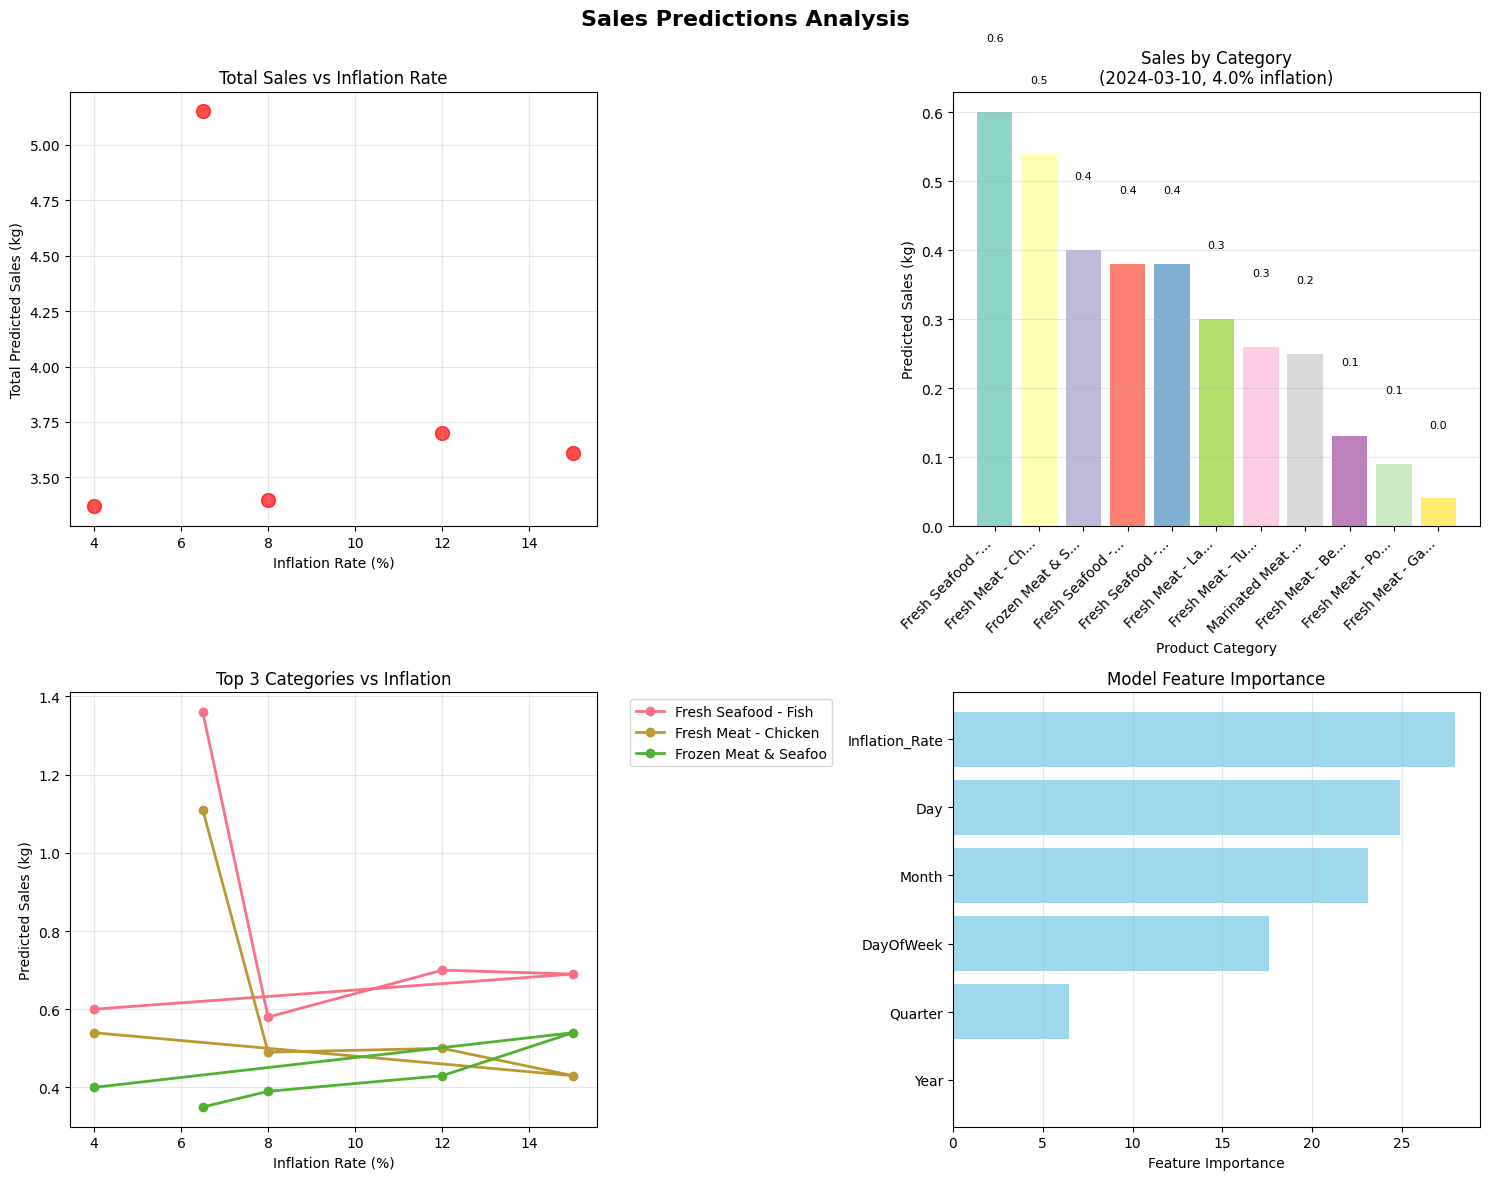

In [41]:
if model_data is not None:
    print("\n" + "=" * 50)
    print("MULTIPLE SCENARIO TESTING")
    print("=" * 50)
    
    test_scenarios = [
        ("2024-01-15", 6.5, "Low inflation scenario"),
        ("2024-06-15", 8.0, "Medium inflation scenario"),
        ("2024-12-01", 12.0, "High inflation scenario"),
        ("2025-03-20", 15.0, "Very high inflation scenario"),
        ("2024-03-10", 4.0, "Very low inflation scenario")
    ]
    
    results_df = []
    
    for date, inflation, description in test_scenarios:
        prediction = predict_sales_from_model(model_data, date, inflation)
        
        if prediction:
            print(f"\n📊 {description}")
            print(f"   Date: {date}, Inflation: {inflation}%")
            
            row_data = {
                'Date': date,
                'Inflation_Rate': inflation,
                'Scenario': description
            }
            row_data.update(prediction)
            results_df.append(row_data)
            
            # Show top 3 categories
            sorted_categories = sorted(prediction.items(), key=lambda x: x[1], reverse=True)[:3]
            print("   Top 3 categories:")
            for i, (cat, sales) in enumerate(sorted_categories, 1):
                print(f"   {i}. {cat}: {sales:.2f} kg")
    
    # Convert to DataFrame for analysis
    if results_df:
        results_df = pd.DataFrame(results_df)
        print(f"\n✅ Generated {len(results_df)} predictions")

# Cell 5: Visualize predictions
if model_data is not None and 'results_df' in locals():
    print("\n" + "=" * 50)
    print("PREDICTION VISUALIZATION")
    print("=" * 50)
    
    # Create visualizations
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    fig.suptitle('Sales Predictions Analysis', fontsize=16, fontweight='bold')
    
    # 1. Total sales vs inflation rate
    category_cols = model_data['category_columns']
    results_df['Total_Sales'] = results_df[category_cols].sum(axis=1)
    
    axes[0, 0].scatter(results_df['Inflation_Rate'], results_df['Total_Sales'], 
                       c='red', alpha=0.7, s=100)
    axes[0, 0].set_xlabel('Inflation Rate (%)')
    axes[0, 0].set_ylabel('Total Predicted Sales (kg)')
    axes[0, 0].set_title('Total Sales vs Inflation Rate')
    axes[0, 0].grid(True, alpha=0.3)
    
    # 2. Sales by category (bar chart for latest prediction)
    latest_pred = results_df.iloc[-1]
    category_sales = [(cat, latest_pred[cat]) for cat in category_cols]
    category_sales.sort(key=lambda x: x[1], reverse=True)
    
    categories, sales = zip(*category_sales)
    colors = plt.cm.Set3(np.linspace(0, 1, len(categories)))
    
    bars = axes[0, 1].bar(range(len(categories)), sales, color=colors)
    axes[0, 1].set_xlabel('Product Category')
    axes[0, 1].set_ylabel('Predicted Sales (kg)')
    axes[0, 1].set_title(f'Sales by Category\n({latest_pred["Date"]}, {latest_pred["Inflation_Rate"]}% inflation)')
    axes[0, 1].set_xticks(range(len(categories)))
    axes[0, 1].set_xticklabels([cat[:15] + '...' if len(cat) > 15 else cat 
                                for cat in categories], rotation=45, ha='right')
    axes[0, 1].grid(True, alpha=0.3, axis='y')
    
    # Add value labels on bars
    for bar, value in zip(bars, sales):
        axes[0, 1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.1,
                        f'{value:.1f}', ha='center', va='bottom', fontsize=8)
    
    # 3. Inflation impact on top categories
    top_3_categories = [cat for cat, _ in category_sales[:3]]
    
    for i, category in enumerate(top_3_categories):
        axes[1, 0].plot(results_df['Inflation_Rate'], results_df[category], 
                        marker='o', label=category[:20], linewidth=2, markersize=6)
    
    axes[1, 0].set_xlabel('Inflation Rate (%)')
    axes[1, 0].set_ylabel('Predicted Sales (kg)')
    axes[1, 0].set_title('Top 3 Categories vs Inflation')
    axes[1, 0].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    axes[1, 0].grid(True, alpha=0.3)
    
    # 4. Model feature importance (if available)
    try:
        feature_importance = model_data['model'].get_feature_importance()
        feature_names = model_data['feature_columns']
        
        importance_df = pd.DataFrame({
            'Feature': feature_names,
            'Importance': feature_importance
        }).sort_values('Importance', ascending=True)
        
        axes[1, 1].barh(importance_df['Feature'], importance_df['Importance'], 
                        color='skyblue', alpha=0.8)
        axes[1, 1].set_xlabel('Feature Importance')
        axes[1, 1].set_title('Model Feature Importance')
        axes[1, 1].grid(True, alpha=0.3, axis='x')
        
    except Exception as e:
        axes[1, 1].text(0.5, 0.5, f'Feature importance\nnot available\n\nError: {str(e)}', 
                        ha='center', va='center', transform=axes[1, 1].transAxes)
        axes[1, 1].set_title('Feature Importance')
    
    plt.tight_layout()
    plt.show()

# Cell 6: Interactive prediction function
def interactive_prediction():
    """Interactive function for making predictions"""
    if model_data is None:
        print("❌ Model not loaded. Cannot make predictions.")
        return
    
    print("\n" + "=" * 50)
    print("INTERACTIVE PREDICTION")
    print("=" * 50)
    
    while True:
        try:
            print("\nEnter prediction parameters (or 'quit' to exit):")
            
            date_input = input("Date (YYYY-MM-DD): ").strip()
            if date_input.lower() == 'quit':
                break
            
            inflation_input = input("Inflation Rate (%): ").strip()
            if inflation_input.lower() == 'quit':
                break
            
            # Validate inputs
            try:
                datetime.strptime(date_input, '%Y-%m-%d')
                inflation_rate = float(inflation_input)
            except ValueError as e:
                print(f"❌ Invalid input: {e}")
                continue
            
            # Make prediction
            prediction = predict_sales_from_model(model_data, date_input, inflation_rate)
            
            if prediction:
                print(f"\n🔮 Prediction Results:")
                print(f"📅 Date: {date_input}")
                print(f"📈 Inflation Rate: {inflation_rate}%")
                print("\n🛒 Predicted Sales (kg):")
                print("-" * 40)
                
                total = 0
                for category, sales in sorted(prediction.items(), key=lambda x: x[1], reverse=True):
                    print(f"{category:<30}: {sales:>8.2f} kg")
                    total += sales
                
                print("-" * 40)
                print(f"{'TOTAL':<30}: {total:>8.2f} kg")
                
        except KeyboardInterrupt:
            print("\n\nExiting...")
            break
        except Exception as e:
            print(f"❌ Error: {e}")